## FAKE NEWS DETECTOR - TRANSFORMERS

### PLAN OF ACTION

- Load the dataset, i.e. combine it into one, and create true / false labels
- Then, utilizing HuggingFace's Transformers library, retrieve the pre-trained BERT model to use as the foundation of a Fake News Detection Model. BERT has incredible language understanding abilities. As a result, it will help the model better grasp news context and hence generate educated predictions about whether news is false or not - The Base Model and general architecture are then defined. For example, we may use PyTorch to define, train, and evaluate neural network models.
- After that, we freeze the weights on the BERT beginning layers. If we do not accomplish this, we will lose all of our past knowledge.
- Next, we add new Trainable Layers. In general, feature extraction layers are the only information from the basic model that we utilize. We must add additional layers on top of the model to forecast its particular jobs. Furthermore, we establish a new output layer because the pre-trained model's ultimate output will almost definitely differ from the result we desire for our model, which is binary 0 and 1.
- The final stage is to fine-tune our model. Making minor tweaks to the model to improve it.
- After that, we use our Fake News Detection Model on unseen data to create predictions.

### Imports

In [3]:
! pip install transformers
! pip install pycaret
! pip install scikit-learn

#### Scikit-learn
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#### Transformers
import transformers
from transformers import AutoModel, BertTokenizerFast
from transformers import AdamW

#### Pytorch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#### Others
import numpy as np
import pandas as pd
import pycaret
import matplotlib.pyplot as plt
import sys

### Constants

In [4]:
DATA_BASE_PATH = "./data/bert/en/"
TRAIN_RATIO = 0.7
TEST_RATIO = 0.3
PYTORCH_BATCHS_SIZE = 32
TRAINING_EPOCHS = 2 # Number of training epochs

------------------------------------------- FROM HERE USE COLLAB (WITH GPU)

Once we are on Colab, activate the GPU runtime by clicking on

Runtime -> Change runtime type -> Select GPU.

In [5]:
# specify GPU
device = torch.device("cuda")

In [6]:
# Check if we are on Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:  # Set Working Directory - if working on Local Machine
    DATA_BASE_PATH = "./"
else: # Set Working Directory - if working on Google Drive
    # Mount Google Drive - applicable, if working on Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/1_LiveProjects/Project11_FakeNewsDetection

### Load data

The dataset chosen comes from Kaggle: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset.

It has two separate .csv files, one having the real news, called "True.csv" and another one, having the fake news, called "Fake.csv". Both files have the exact same data form.

They both include the title of the news, the entire news article text, the subject, which is basically the category of news and the date on which it was published.

Here, we install Huggingface’s transformers library, which allows us to import a wide range of transformer-based pre-trained models.

([<matplotlib.patches.Wedge at 0x7b20e1d18c40>,
 [Text(-1.1968727067385088, -0.0865778485782335, 'Fake'),
  Text(1.1968726986325005, 0.08657796063754254, 'True')],
 [Text(-0.6981757455974634, -0.05050374500396954, '52.3%'),
  Text(0.6981757408689586, 0.05050381037189981, '47.7%')])

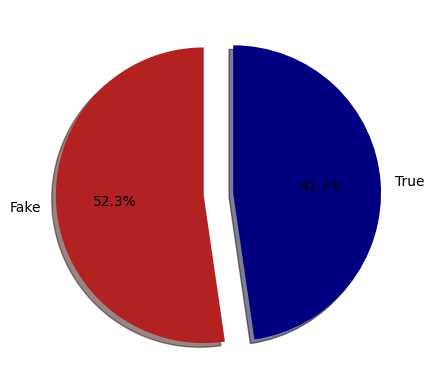

In [7]:
# Load Dataset
true_data = pd.read_csv(DATA_BASE_PATH + 'True.csv')
fake_data = pd.read_csv(DATA_BASE_PATH + 'Fake.csv')

# Generate labels True/Fake under new Target Column in 'true_data' and 'fake_data'
true_data['Target'] = ['True']*len(true_data)
fake_data['Target'] = ['Fake']*len(fake_data)

# Merge 'true_data' and 'fake_data', by random mixing into a single df called 'data'
data = true_data.append(fake_data).sample(frac=1).reset_index().drop(columns=['index'])

# Target column is made of string values True/Fake, let's change it to numbers 0/1 (Fake=1)
data['label'] = pd.get_dummies(data.Target)['Fake']

# Checking if our data is well balanced
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

First, we import genuine and fake csv files into a pandas dataframe. Then, in the 'Target' column, we insert the labels True / Fake. Finally, we use random mixing to combine the two dataframes into a single dataframe.

Following that, the target column contains string values that a machine cannot interpret. As a result, we must convert them to numeric representation. To do this, we utilize Pandas get_dummies to construct a new column named label, in which we assign 1 to all Fake labels and 0 to all True labels. We may use a pie chart at the end to see if our data is balanced across the two labels. As you can see, our data is rather balanced.

Following that, we divided our data into 70 % trainning and 30 % validation.

In [8]:
# Train-Validation-Test set split into 70:15:15 ratio

# Train-Temp split (70:30 -> 0.3 OF 100 TEST)
train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=TEST_RATIO,
                                                                    stratify=data['Target'])
# Validation-Test split (15:15 -> 0.5 OF 30 TEST)
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

### Preprocessing

For this use case, these files shall be merged into a single large dataset, and add a new column ‘Label’, that will have ‘true’ mentioned against all observations from the true.csv and ‘fake’ mentioned against the observations from fake.csv

Now we come to the BERT fine-tuning stage, where we shall perform transfer learning.

The steps are the following:

- First up, we import BERT-base model that has 110 million parameters. Along with it, we also import the BERT Tokenizer
- We preprocess our input data. We shall use the title of the news article to train our model.
- Now, let’s figure out how to standardize the word length of our news titles, as it would vary from one article title to another. For this, we plot a word count histogram, to understand what the typical word length is like.

Text(0, 0.5, 'Number of texts')

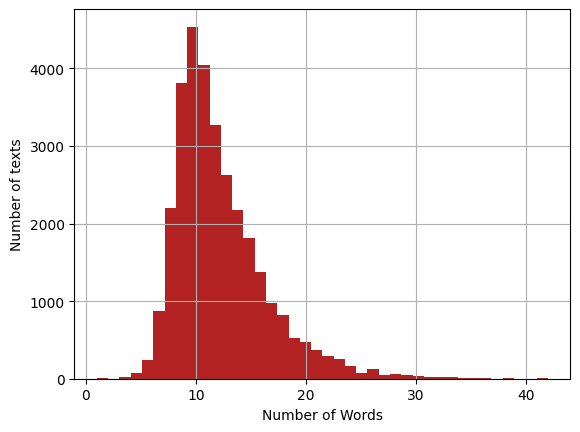

In [9]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]
pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

#### >>>>> NOTE

We can see the majority of titles have word length under 15 words. So, we shall perform padding on all our titles to limit them to 15 words in the tokenization stage.

### Tokenization

In addition, we transform integer sequences to tensors. Finally, data loaders for both the train and validation sets are defined. During the training phase, these data loaders will send batches of train and validation data to the model.

In [10]:
# Majority of titles above have word length under 15. So, we set max title length as 15
max_length_content = 15

# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_length_content,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_length_content,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_length_content,
    pad_to_max_length=True,
    truncation=True
)

# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Data Loader structure definition
train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=PYTORCH_BATCHS_SIZE)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=PYTORCH_BATCHS_SIZE)
                                                              # dataLoader for validation set

Following that, we will freeze pre-trained model weights before fine-tuning it.This will prevent model weights from being updated during fine-tuning.

In [11]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

### Architecture

This will be the definition of the model architecture

In [21]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function

    def forward(self, sent_id, mask):           # define the forward pass
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

In [22]:
model = BERT_Arch(bert)

# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate

# Define the loss function
cross_entropy  = nn.NLLLoss()

We are using PyTorch for defining, training, & evaluating our deep learning model. Post our BERT network, we are adding dense layers 1 & 2 followed by softmax activation. Then, we define our hyperparameters; we are using AdamW as our optimizer.

#### >>>>> NOTE

Then we define our loss function. And lastly, we are keeping number of epochs to 2. With Colab’s free GPU, one epoch might take up to 20 mins.

### Train and evaluate

BERT is a large neural network design with a large number of parameters ranging from 100 million to more than 300 million. Overfitting might occur if a BERT model was trained from scratch on a tiny dataset. As a result, it is preferable to begin with a pre-trained BERT model that was trained on a large dataset. We may then train the model again on our reduced dataset, a technique known as model fine-tuning. There are three ways that may be used to accomplish this:

- The first is to train the entire architecture (the pre-trained weights of the entire model are updated on the new dataset), after which we may train the complete pre-trained model on our dataset and feed the result to a softmax layer. In this situation, the mistake is propagated throughout the architecture, and the model's pre-trained weights are adjusted depending on the new dataset.
- The second method is to train certain layers while freezing others (by freezing the weights of the beginning layers while retraining just the upper layers using tria-&-test), which is equivalent to partly training a pre-trained model. We maintain the weights of the model's early layers fixed while retraining just the upper levels. We may use trial and error to determine how many layers to use.
- And the third one, is to Freeze the entire architecture (and attach a few neural network layers of our own and train the new model), where we basically freeze all the layers of the pre-trained model and attach a few neural network layers of our own and train this new model. Note that the weights of only the attached layers will be updated during model training.

In [14]:
# Defining training function
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

In [15]:
def evaluate():
  print("\nEvaluating...")
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):    # Iterate over batches
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

Start fine tunning

In [16]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(TRAINING_EPOCHS):
    print('\n Epoch {:} / {:}'.format(epoch + 1, TRAINING_EPOCHS))
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c1_fakenews_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of    983.
  Batch   700  of    983.
  Batch   750  of    983.
  Batch   800  of    983.
  Batch   850  of    983.
  Batch   900  of    983.
  Batch   950  of    983.

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Loss: 0.564
Validation Loss: 0.487

 Epoch 2 / 2
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  

### Visualizations and metrics

Build a classification report on the test set using our fake news model:

In [24]:
# load weights of best model
path = 'c1_fakenews_weights.pt'
model.load_state_dict(torch.load(path))

with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.79      0.91      0.84      3212
           1       0.90      0.78      0.84      3523

    accuracy                           0.84      6735
   macro avg       0.85      0.84      0.84      6735
weighted avg       0.85      0.84      0.84      6735



In [25]:
# load weights of best model
path = 'best_model_fakenews_weights.pt'
model.load_state_dict(torch.load(path))

with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

RuntimeError: ignored

### Predictions

Try runnning predictions on these sample news titles. First two are fake and the next two are real.

In [18]:
# testing on unseen data
unseen_news_text = [
    "Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",     # Fake
    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",               # Fake
    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",           # True
    "Trump administration issues new rules on U.S. visa waivers"                          # True
]
# tokenize and encode sequences in the test set
max_length_content = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = max_length_content,
    pad_to_max_length=True,
    truncation=True
)
unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()
preds = np.argmax(preds, axis = 1)

In [19]:
preds

array([1, 0, 0, 0])

### Conclusions

Both precision & recall for class 1 are quite high which means that the model predicts this class pretty well. Looking at the recall for class 1, it is 0.85 which means that the model was able to correctly classify 85% of the fake news as fake. Precision is 0.92, which means that 92% of the fake news classifications by the model, are actually fake news.